# Prepare data

## Import data

In [1]:
import pandas as pd
import numpy as np
import heapq
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation
from keras.layers import LSTM
import json
from tensorflow.keras.optimizers import RMSprop

## Read json file

In [2]:
# Load the JSON file into a dictionary
with open('train.json', 'r') as f:
    data = json.load(f)

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame.from_dict(data)

# Print the unique values in the 'tag' column
print(df['tag'].unique())

['phone call' 'meeting' 'face-to-face conversation' 'general chatting'
 'presentation' 'training']


In [3]:
df

,id,tag,title,original_language,conversation
0,190329_J07_03,phone call,ن¼‌è¨€مپ¸مپ®وٹکم‚ٹè؟”مپ—é›»è©±و‰“مپ،هگˆم‚ڈمپ›و...,ja,"[{'no': 1, 'ja_speaker': 'هœںن؛•مپ•م‚“', 'en_s..."
1,190329_J06_11,meeting,و ھن¸»ç·ڈن¼ڑمپ«é–¢مپ™م‚‹ه½¹ه“،هگ‘مپ‘èھ¬وکژï¼ˆï...,ja,"[{'no': 1, 'ja_speaker': 'é«کç”°مپ•م‚“', 'en_s..."
2,190329_J06_10,meeting,و ھن¸»ç·ڈن¼ڑمپ«é–¢مپ™م‚‹ه½¹ه“،هگ‘مپ‘èھ¬وکژï¼ˆï...,ja,"[{'no': 1, 'ja_speaker': 'هڈ‹ن؛•مپ•م‚“', 'en_s..."
3,190329_J06_09,face-to-face conversation,ن؟،è¨—éٹ€è،Œمپ‹م‚‰و ھن¸»هگچç°؟م‚’هڈ—é ک,ja,"[{'no': 1, 'ja_speaker': 'é«کç”°مپ•م‚“', 'en_s..."
4,190329_J06_08,face-to-face conversation,و ھن¸»ç·ڈن¼ڑمپ¸مپ®è‡¨ه ´è¦پè«‹,ja,"[{'no': 1, 'ja_speaker': 'é«کç”°مپ•م‚“', 'en_s..."
...,...,...,...,...,...
665,190315_E001_05,presentation,Presentation: Company introduction,en,"[{'no': 1, 'en_speaker': 'Mr. Asano Yuki', 'ja..."
666,190315_E001_04,training,Training: training a new employee,en,"[{'no': 1, 'en_speaker': 'Mr. Ben Sherman', 'j..."
667,190315_E001_03,general chatting,General chatting: Company Christmas party,en,"[{'no': 1, 'en_speaker': 'Ms. Amy Lin', 'ja_sp..."
668,190315_E001_02,phone call,Phone call: requesting a lunch meeting.,en,"[{'no': 1, 'en_speaker': 'Mr. John Smith', 'ja..."


## Concatenates ‘conversation’ column  And normalizes It

In [4]:
df_convs = pd.concat([pd.json_normalize(df['conversation'][i]) for i in range(len(df))],ignore_index=True)
train_en = df_convs["en_sentence"].values.tolist()
train_ja = df_convs["ja_sentence"].values.tolist()

In [5]:
df_convs

,no,ja_speaker,en_speaker,ja_sentence,en_sentence
0,1,هœںن؛•مپ•م‚“,Doi-san,مپ¯مپ„م€پKç¤¾م‚·م‚¹مƒ†مƒ é–‹ç™؛éƒ¨مپ§مپ™م€‚,Hi this is the systems development department ...
1,2,é«که¸‚مپ•م‚“,Takaichi-san,Hç¤¾مپ®é«که¸‚مپ¨ç”³مپ—مپ¾مپ™م€‚,My name is Takaichi from Company H.
2,3,é«که¸‚مپ•م‚“,Takaichi-san,مپ„مپ¤م‚‚مپٹن¸–è©±مپ«مپھمپ£مپ¦مپٹم‚ٹمپ¾مپ™م€‚,Thank you as always.
3,4,هœںن؛•مپ•م‚“,Doi-san,مپ“مپ،م‚‰مپ“مپ‌م€پمپٹن¸–è©±مپ«مپھمپ£مپ¦مپٹم‚ٹم...,Thank you as always as well.
4,5,é«که¸‚مپ•م‚“,Takaichi-san,ç¨²ç”°مپ•م‚“مپ¯مپ„م‚‰مپ£مپ—م‚ƒمپ„مپ¾مپ™مپ‹ï¼ں,Is Inada-san there?
...,...,...,...,...,...
19995,28,مƒœمƒ– م‚¯مƒƒم‚¯مپ•م‚“,Mr. Bob Cook,ن»ٹو—¥مپ®5و™‚مپ¾مپ§مپ«و›¸مپچن¸ٹمپ’مپ¾مپ™م€‚,I'll finish it by 5 o'clock today.
19996,29,م‚¢مƒ« م‚¸مƒ§مƒ³م‚½مƒ³مپ•م‚“,Mr. Al Johnson,ه®Œç’§مپ مپ­م€‚,Perfect.
19997,30,م‚¢مƒ« م‚¸مƒ§مƒ³م‚½مƒ³مپ•م‚“,Mr. Al Johnson,وکژو—¥م‚¼مƒچمƒ©مƒ«مƒ‍مƒچمƒ¼م‚¸مƒ£مƒ¼مپ«Aç¤¾مپ®...,I'll go talk to the general manager tomorrow t...
19998,31,م‚¢مƒ« م‚¸مƒ§مƒ³م‚½مƒ³مپ•م‚“,Mr. Al Johnson,ه½¼مپŒAç¤¾م‚’و°—مپ«ه…¥مپ£مپ¦مپڈم‚Œمپ¦م€پوٹ•è³‡...,Hopefully he will like Company A and make the ...


In [6]:
train_en[:10]

['Hi this is the systems development department of Company K.',
 'My name is Takaichi from Company H.',
 'Thank you as always.',
 'Thank you as always as well.',
 'Is Inada-san there?',
 'It seems I got a call from him around 1 hour ago.',
 'Yes, let me switch you over.',
 'Please wait a moment.',
 'Inada-san, you have a call from Mr. Takaichi of Company H.',
 'Hello, this is Inada.']

## Concat all english messages

In [7]:
text = ' '.join(train_en[0:10000])
print('length of the corpus is: :', len(text))

length of the corpus is: : 533319


## Tokenize

In [8]:
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

In [9]:
# get unique words
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [10]:
unique_words[1000:1020]

array(['Seriously', 'Service', 'Seven', 'Shall', 'Shanghai', 'She',
       'Shibata', 'Shibuya', 'Shiota', 'Shiraishi', 'Shiroki', 'Shirota',
       'Shizuo', 'Shodoshima', 'Shop', 'Should', 'Shouldn', 'Shuji',
       'Silence', 'Silicone'], dtype='<U16')

## ModelBuilding

In [11]:
# model input = prev_words
# model output = next_words

WORD_LENGTH = 5
next_words = []
prev_words = []
for j in range(len(words) - WORD_LENGTH):
    prev_words.append(words[j:j + WORD_LENGTH])
    next_words.append(words[j + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['Hi', 'this', 'is', 'the', 'systems']
development


In [12]:
# convert features into numpy arrays
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
# prepare word2id index
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1
word2id = unique_word_index

In [13]:
# prepare id2word index ==> for inference
id2word = {y:x for x,y in unique_word_index.items()}

## Train

In [14]:
# build model
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

In [15]:
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=2, shuffle=True).history

Epoch 1/2
769/769 [==============================] - 113s 144ms/step - loss: 6.2286 - accuracy: 0.0767 - val_loss: 5.7895 - val_accuracy: 0.1314
Epoch 2/2
769/769 [==============================] - 110s 143ms/step - loss: 5.4774 - accuracy: 0.1455 - val_loss: 5.5055 - val_accuracy: 0.1491


## Evaluate

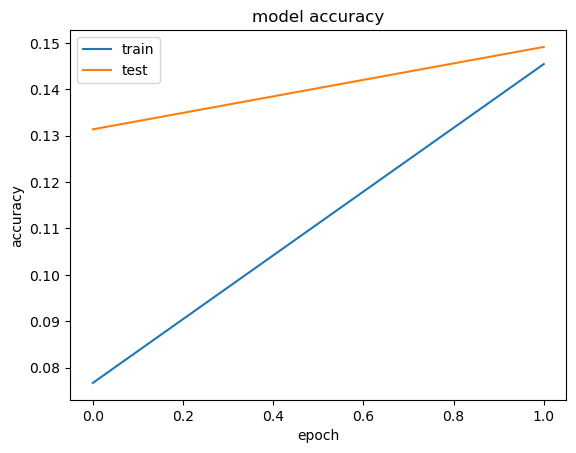

In [16]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

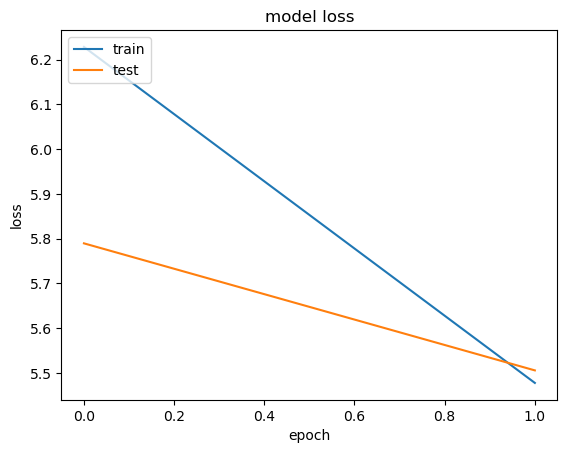

In [17]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

# Communicate 

In [18]:

def prepare_input(text):
    words = tokenizer.tokenize(text)
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(words):
        x[0, t, word2id[word]] = 1.
        
    return x

In [19]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)
     

In [20]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_word = id2word[next_index]
        text = text[1:] + next_word
        completion += next_word
        
        if len(original_text + completion) + 2 > len(original_text) and next_word == ' ':
            return completion
     

In [21]:
def predict_next_word(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [id2word[idx] for idx in next_indices]
     

### Starting sentence: "I look forward to working" 

In [36]:
# Model only accept input with 5 words
input="I look forward to working"
print(predict_next_word(input, 5))
'I look forward to working with'

['with', 'on', 'about', 'I', 'Yes']


'I look forward to working with'

In [34]:
input="look forward to working with"
print(predict_next_word(input, 5))
'I look forward to working with you'

['you', 'now', 'the', 'I', 'this']


'I look forward to working with you'

In [37]:
input="forward to working with you, "
print(predict_next_word(input, 5))

['I', 'Yes', 'and', 'for', 'at']


In [40]:
input="to working with you, I"
print(predict_next_word(input, 5))

['m', 'll', 'am', 'see', 'will']


In [41]:
input="working with you, I'm"
print(predict_next_word(input, 5))

['thinking', 'not', 'very', 'sure', 'working']


In [44]:
input="with you, I'm thinking"
print(predict_next_word(input, 5))

['of', 'I', 'about', 'it', 'on']


In [45]:
input="you, I'm thinking of"
print(predict_next_word(input, 5))

['the', 'that', 'it', 'one', 'a']


In [47]:
input="I'm thinking of the"
print(predict_next_word(input, 5))

['company', 'office', 'new', 'sales', 'meeting']


Final sentence: I look forward to working with you, I'm thinking of the company.